In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import networkit as nk
import pandas as pd
import numpy as np
from pylab import rcParams
import math
import sys

In [137]:
def flatten (l):
    result = []
    for s in l:
        for el in s:
            result.append(el)
    return result

def shorten(name):
    return name.lstrip('cost_matrix_component_nr_')

In [138]:
def getMean(df, res):
    result_set = df[res].values
    if (len(result_set) == 0):
        return np.nan
    else:
        return sum(result_set) / len(result_set)

In [139]:
def getEffect(df, b, res, b_v, percentual):
    ref = defaults[b]
    on = getMean(df.loc[(df[b] == b_v)], res)
    off = getMean(df.loc[(df[b] == ref)], res)
    if percentual:
        return (1 - (on/off)) * 100
    else:    
        return off - on

In [140]:
def getAvgEffect(df, a, b, res, b_v, percentual):
    values = list(set(df[a].tolist()))
    effect_sum = 0
    for a_v in values:
        effect_sum = effect_sum + getEffect(df.loc[(df[a] == a_v)], b, res, b_v, percentual)
    return effect_sum / len(values)

In [141]:
def writeTex(output_df, table_name, title):
    output_df = output_df.reset_index()
    title = title.replace('_', '\_')
    print(title)
    print(output_df)
    output_file.write(title)
    output_file.write('\\\\\n')
    output_file.write('Fixing ')
    for (column, values) in fixed.items():
        output_file.write(column + ' = ' + str(values).replace('[', '\lbrack ').replace(']', '\\rbrack\ ').replace('_', '\_'))
    output_file.write('\\\\\n')
    output_df.to_latex(tex_dir + table_name +'.tex', index=False)
    output_file.write('\input{./' + table_name + '.tex}\n')
    output_file.write('\\\\ \\\\\n')
    
def writePlotTex(plt, name):
    plt.savefig(plot_dir + name, bbox_inches='tight', dpi=300)
    plt.show()
    output_file.write('\includegraphics[width=\\textwidth]{../plots/' + name + '}\n')
    output_file.write('\\newpage \n \\noindent ')

In [142]:
def getOverview(df, exp, res, average = False, effect = False, percentual = False):
    table_name = str(exp[len(exp) - 1]) + '_' + res + '_table'
    title = ''
    if average:
        table_name += '_avg'
        effect = True
    if effect:
        table_name += '_effect'
    if percentual:
        table_name += '_percentual'
    table_name +=  '_' + str(len(exp))
        
    if effect:
        if average:
            if percentual:
                title = 'Average percentual effect '
            else:
                title = 'Average effect '
        else:
            if percentual:
                title = 'Percentual effect '
            else:
                title = 'Effect '
        title += 'of ' + str(exp[len(exp) - 1]) + ' on ' + res
    else:
        title = res + ' depending on ' + str(exp[len(exp) - 1])

    if average:
        if(exp[0] == 'graph'):
            values = [[graph_set]]
        else:
            values =[['']]
        values += [list(set(df[exp[i]].tolist())) for i in range(1, len(exp))]
    else:
        values = [list(set(df[e].tolist())) for e in exp]
    
    if effect:
        values[len(exp) - 1].remove(defaults[exp[len(exp) - 1]])
    data_rows = []
    if(len(exp) == 2):
        for e0 in values[0]:
            data_row = []
            for e1 in values[1]:
                if(average):
                    data_row.append(getAvgEffect(df, exp[0], exp[1], res, e1, percentual))
                else:
                    if(effect):
                        data_row.append(getEffect(df.loc[(df[exp[0]] == e0)], exp[1], res, e1, percentual))
                    else:
                        data_row.append(getMean(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1)], res))
            data_rows.append(np.array(data_row))
        output_df = pd.DataFrame(data_rows, index=values[0], columns=values[1])
        if (not average) and (exp[0] == 'graph'):
            node_counts = [df.loc[df['graph'] == g]['n'].values[0] for g in values[0]]
            output_df.insert(0, column='n', value=node_counts)

    if(len(exp) == 3):
        values[1].sort()
        for e0 in values[0]:
            for e1 in values[1]:
                data_row = []
                for e2 in values[2]:
                    if(average):
                        data_row.append(getAvgEffect(df.loc[(df[exp[1]] == e1)], exp[0], exp[2], res, e2, percentual))
                    else:
                        if(effect):
                            data_row.append(getEffect(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1)], exp[2], res, e2, percentual))
                        else:
                            data_row.append(getMean(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df[exp[2]] == e2)], res))
                data_rows.append(np.array(data_row))
        row_headers = [np.array(flatten([[e0 for e1 in values[1]] for e0 in values[0]])), 
                    np.array(flatten([[e1 for e1 in values[1]] for e0 in values[0]]))]
        output_df = pd.DataFrame(data_rows, index=row_headers, columns=values[2])
        output_df.index = output_df.index.set_names([exp[0], exp[1]])
        if (not average) and (exp[0] == 'graph'):
            node_counts = [df.loc[df['graph'] == g]['n'].values[0] for g in output_df.index.get_level_values('graph')]
            output_df.insert(0, column='n', value=node_counts)
        
    if(len(exp) == 4):
        for e0 in values[0]:
            for e1 in values[1]:
                data_row = []
                for e2 in values[2]:
                    for e3 in values[3]:
                        if(average):
                            data_row.append(getAvgEffect(df.loc[(df[exp[1]] == e1) & (df[exp[2]] == e2)], exp[0], exp[3], res, e3, percentual))
                        else:
                            if(effect):
                                data_row.append(getEffect(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df[exp[2]] == e2)], exp[3], res, e3, percentual))
                            else:
                                data_row.append(getMean(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df[exp[2]] == e2) & (df[exp[3]] == e3)], res))
                data_rows.append(np.array(data_row))
        row_headers = [np.array(flatten([[e0 for e1 in values[1]] for e0 in values[0]])), 
                    np.array(flatten([[e1 for e1 in values[1]] for e0 in values[0]]))]
        columns = np.array(flatten([[[e2, e3] for e3 in values[3]] for e2 in values[2]]))
        output_df = pd.DataFrame(data_rows, index=row_headers, columns=columns)
        output_df.index = output_df.index.set_names([exp[0], exp[1]])
        
    output_df = output_df.round(2)   
    writeTex(output_df, table_name, title)
    return table_name  

In [143]:
def prepare(scenario, fixed):
    df = dfs[scenario]
    for column, values in fixed.items():
        possible_dfs = []
        for value in values:
            possible_dfs.append(df.loc[(df[column] == value)])
        df = pd.concat(possible_dfs)
    return df
    

In [144]:
#exp[0] das wird gezählt (graphen)
#exp[1] hierfür jeweils ein diagramm 
#exp[2] hierfür jeweils eine Linie (initializations)
#exp[3] wenn definiert wird effekt des ersten untersucht
def percentualPlot(df, exp, res):
    values = [list(set(df[e].tolist())) for e in exp]
    values[len(exp) - 1].remove(defaults[exp[len(exp) - 1]])
    if(len(exp) == 4):
        for e1 in values[1]:
            fig, ax = plt.subplots()
            min_p = 0
            max_p = 0
            for e2 in values[2]:
                p = [getEffect(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df[exp[2]] == e2)], exp[3], res, values[3][0], True) for e0 in values[0]]
                p.sort(reverse = True)
                plt.plot([((i+1) / len(p)) * 100 for i in range(len(p))], p, label = e2)
                if p[0] > max_p:
                    max_p = p[0]
                if p[len(p) - 1] < min_p:
                    min_p = p[len(p) - 1]
            plt.ylabel("minimum percentual effect")
            plt.xlabel("% instances")
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=True, ncol=len(values[2]))
            ax.set_ylim(max_p * 1.1, min_p * 1.1)
            plt.title('Percentual effect of ' + exp[2] +  ' on ' + res + ', ' + exp[1] + "=" + str(e1))
            writePlotTex(plt, res + '_' + exp[3] + '_' + exp[2] + '_' + exp[1] + '_'+ str(e1) + '_percentual.png')
            plt.show()
    if(len(exp) == 3):
        for e1 in values[1]:
            fig, ax = plt.subplots()
            min_p = 0
            max_p = 0
            for e2 in values[2]:
                p = [getEffect(df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1)], exp[2], res, e2, True) for e0 in values[0]]
                p.sort(reverse = True)
                plt.plot([((i+1) / len(p)) * 100 for i in range(len(p))], p, label = e2)
                if p[0] > max_p:
                    max_p = p[0]
                if p[len(p) - 1] < min_p:
                    min_p = p[len(p) - 1]
                    plt.xlabel('n')
            plt.ylabel("minimum percentual effect")
            plt.xlabel("% instances")
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=True, ncol=len(values[2]))
            ax.set_ylim(max_p * 1.1, min_p * 1.1)
            plt.title('Percentual effect of ' + exp[2] +  ' on ' + res + ', ' + exp[1] + "=" + str(e1))
            writePlotTex(plt, res + '_' + exp[2] + '_' + exp[1] + '_'+ str(e1) + '_percentual.png')
    if(len(exp) == 2):
        fig, ax = plt.subplots()
        min_p = 0
        max_p = 0
        for e1 in values[1]:
            p = [getEffect(df.loc[(df[exp[0]] == e0)], exp[1], res, e1, True) for e0 in values[0]]
            p.sort(reverse = True)
            plt.plot([((i+1) / len(p)) * 100 for i in range(len(p))], p, label = e1)
            if p[0] > max_p:
                max_p = p[0]
            if p[len(p) - 1] < min_p:
                min_p = p[len(p) - 1]
        plt.ylabel("minimum percentual effect")
        plt.xlabel("% instances")
        ax.set_ylim(max_p * 1.1, min_p * 1.1)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=True, ncol=len(values[1]))
        plt.title('Percentual effect of ' + exp[1] + ' on ' + res)
        writePlotTex(plt , res + '_' + exp[2] + '_percentual.png')

In [145]:
def percentualOptimumPlot(df, exp, res):
    values = [list(set(df[e].tolist())) for e in exp]
    graphs = list(set(df['graph'].tolist()))
    if(len(exp) == 2):
        for e0 in values[0]:
            fig, ax = plt.subplots()
            min_p = 0
            max_p = 0
            for e1 in values[1]:
                p = [df.loc[(df[exp[0]] == e0) & (df[exp[1]] == e1) & (df['graph'] == graph)]['optimum_delta_percentual'].values[0] for graph in graphs]
                p.sort()
                plt.plot([((i+1) / len(p)) * 100 for i in range(len(p))], p, label = e1)
                if p[0] > max_p:
                    max_p = p[0]
                if p[len(p) - 1] < min_p:
                    min_p = p[len(p) - 1]
                    plt.xlabel('n')
            plt.ylabel("maximum percent. distance to optimum")
            plt.xlabel("% instances")
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=True, ncol=len(values[1]))
            #ax.set_ylim(max_p * 1.1, min_p * 1.1)
            plt.title('Percentual distance of ' + res + ' to optimum, depending on ' + exp[1]+ ", " + exp[0] + " = " + str(e0))
            writePlotTex(plt, res + '_' + exp[1] + '_' + exp[0] + '_'+ str(e0) + '_optimum_percentual.png')
    if(len(exp) == 1):
        fig, ax = plt.subplots()
        min_p = 0
        max_p = 0
        for e0 in values[0]:
            p = [df.loc[(df[exp[0]] == e0) & (df['graph'] == graph)]['optimum_delta_percentual'].values[0] for graph in graphs]
            p.sort(reverse = True)
            plt.plot([((i+1) / len(p)) * 100 for i in range(len(p))], p, label = e0)
            if p[0] > max_p:
                max_p = p[0]
            if p[len(p) - 1] < min_p:
                min_p = p[len(p) - 1]
        plt.ylabel("maximum percent. distance to optimum")
        plt.xlabel("% instances")
        ax.set_ylim(max_p * 1.1, min_p * 1.1)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=True, ncol=len(values[0]))
        plt.title('Percentual distance of ' + res + ' to optimum, depending on ' + exp[0])
        writePlotTex(plt , res + '_' + exp[2] + '_optimum_percentual.png')

In [146]:
def scatterPlot(df, exp, res):
    markers = [".", "x", "^", "*", "s", "p", "P"]
    graphs = list(set(df['graph'].tolist()))
    x = [getMean(df.loc[(df['graph'] == graph)], 'n') for graph in graphs]
    if len(exp) == 1:
        points = [getMean(df.loc[(df['graph'] == graph)], res) for graph in graphs]
        plt.scatter(x, points)
        plt.title(res + ' depending on number of nodes')
        fig, ax = plt.subplots()
        name = 'scatterplot_' + res
        ax.set_xscale('log')
        plt.xlabel('n')
        plt.ylabel(res)
        writePlotTex(plt, name)
    if len(exp) == 2:
        values = list(set(df[exp[1]].tolist()))
        i = 0
        colors = cm.rainbow(np.linspace(0, 1, len(values)))
        name = 'scatterplot_' + res
        fig, ax = plt.subplots()
        for v in values:
            plt.title(res + ' depending on number of nodes, for ' + exp[1] + ' = ' + v)
            points = [getMean(df.loc[(df['graph'] == graph) & (df[exp[1]] == v)], res) for graph in graphs]
            plt.scatter(x, points, color = colors[i], marker = markers[i], label = v, s=8)
            i += 1
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=True, ncol=len(values))
        plt.xlabel('n')
        plt.ylabel(res)
        ax.set_xlim(left=pow(10, math.log(df['n'].min(), 10)))
        ax.set_xscale('log')
        writePlotTex(plt, name)
        


In [147]:
def initTableCnt(df, usingOptima):
    iters = list(set(df['maxIterations'].tolist()))
    iters.sort()
    inits = list(set(df['initialization'].tolist()))
    graphs = list(set(df['graph'].tolist()))
    output_df = pd.DataFrame(columns=['it']+inits)
    best = dict((i, [0 for i in range(len(inits))]) for i in iters)
    best_vals = {}
    for graph in graphs:
        df_dict = dict((i, df.loc[(df['graph'] == graph) &  (df['maxIterations'] == i)]) for i in iters)
        if usingOptima:
            if graph in optima:
                best_vals = dict((i, optima[graph]) for i in iters)
            else:
                best_vals = dict((i, np.nan) for i in iters)
        else:
            best_vals = dict((i, min(df_dict[i]['edits'].values)) for i in iters)
        for j in range(len(inits)):
            init = inits[j]
            for i in iters:
                if(getMean(df_dict[i].loc[(df_dict[i]['initialization'] == init)], 'edits') == best_vals[i]):
                    best[i][j] = best[i][j] + 1
    for i in range(len(iters)):
        it = iters[i]
        output_df.loc[i] = [it] + best[it]
    output_df.reset_index(drop=True, inplace=True)
    if usingOptima:
        writeTex(output_df, 'init_table_opt', 'Number of graphs for which the initialization strategies ' + 
             'lead to the optimum (if known)')
    else:
        writeTex(output_df, 'init_table_best', 'Number of graphs for which the initialization strategies ' + 
             'lead to the minimum number of achieved edits')

In [148]:
def plot(g):
    global graph_set
    graph_set = g
    global inf_iterations
    inf_iterations = 100
    global plot_dir
    plot_dir = '../output/QTM_gpute2/' + graph_set + '/plots/'
    global tex_dir
    tex_dir = '../output/QTM_gpute2/' + graph_set + '/tex/'
    data_path = '../output/QTM_gpute2/' + graph_set + '/'
    
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    if not os.path.exists(tex_dir):
        os.makedirs(tex_dir)
        
    
    global dfs
    dfs = {'full' : pd.read_csv(data_path  + '/full.csv'), 
           'plateauBound' : pd.read_csv(data_path  + '/plateauBound.csv')}
    
    global defaults
    defaults= {'initialization': 'trivial',
              'randomness': False,
              'sortPaths' : False,
              'plateauSize' : 1,
               'maxIterations' : 5}
    
    global optima
    optima = {'karate' : 21, 'lesmis' : 60, 'dolphins' : 72}
    bio_df = pd.read_csv('../input/biological/bio_data.csv')
    for index, row in bio_df.iterrows():
        optima[shorten(row['Graph'].split('.')[0])] = int(row['k'])
   
    global output_file
    output_file = open(tex_dir + 'tables.tex', 'w+')
    output_file.write('\documentclass{article}\n')
    output_file.write('\\usepackage{geometry} \n ' + 
                         '\geometry{ \n ' + 
                         'a4paper, \n ' + 
                         'total={170mm,257mm}, \n ' + 
                         'left=10mm,  \n ' + 
                         'top=10mm,  \n ' + 
                             '} \n ')
    output_file.write('\\usepackage{booktabs}\n')
    output_file.write('\\usepackage{graphicx}\n')
    output_file.write('\\begin{document}\n')
    output_file.write('\\noindent\n')
    
    global fixed
    

    ######### Analysis of Initialization-strategies - Edits ################
    fixed = {'randomness' : [False],
                'sortPaths' : [True]}
    exploring = ['graph', 'maxIterations', 'initialization']
    res = 'edits'
    input_df = prepare('full', fixed)
    initTableCnt(input_df, False)
    initTableCnt(input_df, True)
    getOverview(input_df, exploring, res, True, True, True)
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, inf_iterations]}
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    output_file.write('\\newpage \n \\noindent ')
    percentualPlot(input_df, exploring, res)
    percentualOptimumPlot(input_df, exploring[1:], res)
    
    ######### Analysis of Initialization-strategies - Dfference to optimum ################
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, inf_iterations]}
    exploring = ['graph', 'maxIterations', 'initialization']
    res = 'optimum_delta_percentual'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    output_file.write('\\newpage \n \\noindent ')

    
    ######### Analysis of Initialization-strategies - usedIterations ################
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [inf_iterations]}
    exploring = ['graph', 'initialization']
    res = 'usedIterations'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, False)
    output_file.write('\\newpage \n \\noindent ')
    scatterPlot(input_df, exploring, res)
    
    ######### Analysis of Initialization-strategies - runningTime ################
    df_name = 'full'
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0]}
    exploring = ['graph', 'initialization']
    res = 'time'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, False)
    output_file.write('\\newpage \n \\noindent ')
    
    ######### Analysis of sortPaths - edits ################
    fixed = {'randomness' : [False],
                'maxIterations' : [0, inf_iterations],
                'initialization' : ['random_insert', 'asc_degree_insert']}
    exploring = ['graph', 'maxIterations', 'initialization', 'sortPaths']
    res = 'edits'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, True)
    output_file.write('\\newpage \n \\noindent ')
    percentualPlot(input_df, exploring, res)
    
    ######### Analysis of randomness - edits ################
    fixed = {'sortPaths' : [True],
                'maxIterations' : [0, inf_iterations],
                'initialization' : ['asc_degree_insert']}
    exploring = ['graph', 'maxIterations', 'randomness']
    res = 'edits'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, True)
    output_file.write('\\newpage \n \\noindent ')
    percentualPlot(input_df, exploring, res)
    
    ######### Analysis of randomness - plateauBound ################
    fixed = {'initialization' : ['editing', 'asc_degree_insert']}
    exploring = ['graph', 'sortPaths', 'initialization', 'plateauSize']
    res = 'edits'
    input_df = prepare('plateauBound', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, True)
    output_file.write('\\newpage \n \\noindent ')
    
    fixed = {'plateauSize' : [100], 'sortPaths' : [True]}
    exploring = ['graph', 'plateauSize', 'initialization']
    res = 'actualPlateau'
    input_df = prepare('plateauBound', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    exploring = ['plateauSize', 'initialization']
    getOverview(input_df, exploring, res, False, False, False)
    output_file.write('\\newpage \n \\noindent ')
    scatterPlot(input_df, ['graph', 'initialization'], res)
    



    ######### Analysis of Convergence ################
    df_name = 'full'
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, 5, inf_iterations]}
    exploring = ['graph', 'initialization', 'maxIterations']
    res = 'edits'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    getOverview(input_df, exploring, res, True, True, False)
    output_file.write('\\newpage \n \\noindent ')
    
    
    output_file.write('\end{document}\n')
    output_file.close()
    
def bq():
    ######### Analysis of Bucket queue effect ################
    fixed = {'randomness' : [False],
                'sortPaths' : [True],
                'maxIterations' : [0, inf_iterations]}
    exploring = ['graph', 'maxIterations', 'initialization']
    res = 'bq_effect'
    input_df = prepare('full', fixed)
    getOverview(input_df, exploring, res, False, False, False)
    exploring = ['maxIterations', 'initialization']
    getOverview(input_df, exploring, res, False, False, False)
    output_file.write('\\newpage \n \\noindent ')
    

In [149]:
def addInformation(graph_set):
    data_path = '../output/QTM_gpute2/' + graph_set + '/'
    dfs = {}
    #scenarios = ['full', 'plateauBound', 'withoutBucketQueue']
    scenarios = ['full', 'plateauBound']
    for scenario in scenarios:
        dfs[scenario] = pd.read_csv(data_path + scenario + '.csv')
    
    
    optima = {'karate' : 21, 'lesmis' : 60, 'dolphins' : 72}
    bio_df = pd.read_csv('../input/biological/bio_data.csv')
    for index, row in bio_df.iterrows():
        optima[row['Graph'].split('.')[0]] = int(row['k'])
    
    df = dfs['full']
    df = df.reset_index()
    optima_column = []
    delta_column = []
    percentual_column = []
    #bq_effect_column = []
    #time_wbq_column = []
    
    #bq_df = dfs['withoutBucketQueue']
    for i, row in df.iterrows():
        graph = row['graph']
        time = df.iloc[[i]]['time'].values[0]
        #bq_time = bq_df.iloc[[i]]['time'].values[0]
        #bq_effect_column.append(bq_time - time)
        #time_wbq_column.append(bq_time)
        if graph in optima:
            optima_column.append(optima[graph])
            delta_column.append(row['edits'] - optima[graph])
            if optima[graph] == 0:
                percentual_column.append((row['edits'] - optima[graph]))
            else :
                percentual_column.append((row['edits'] - optima[graph]) / optima[graph])
        else:
            optima_column.append(np.nan)
            delta_column.append(np.nan)
            percentual_column.append(np.nan)
        
    df.insert(13, column='optimum', value=optima_column)
    df.insert(14, column='optimum_delta', value=delta_column)
    df.insert(15, column='optimum_delta_percentual', value=percentual_column)
    #df.insert(16, column='time_wbq', value=time_wbq_column)
    #df.insert(17, column='bq_effect', value=bq_effect_column)
    dfs['full'] = df
    
    if (graph_set == 'biological'):
        for(name, df) in dfs.items():
            df['graph'] = df['graph'].apply(shorten)
    
    
    dfs['full'].to_csv(data_path +  '/full.csv')
    dfs['plateauBound'].to_csv(data_path + '/plateauBound.csv')

Number of graphs for which the initialization strategies lead to the minimum number of achieved edits
   index   it  trivial  asc_degree_insert  random_insert  editing
0      0    0        0                  2             94        0
1      1    5        0                  8              2       86
2      2  100        0                  7              3       87
Number of graphs for which the initialization strategies lead to the optimum (if known)
   index   it  trivial  asc_degree_insert  random_insert  editing
0      0    0        0                  0              0        0
1      1    5        0                  0              0        0
2      2  100        0                  0              0        0
Average percentual effect of initialization on edits
      graph  maxIterations  asc_degree_insert  random_insert  editing
0  facebook              0              12.66          13.94   -11.58
1  facebook              5               0.07           0.10     0.27
2  facebook        

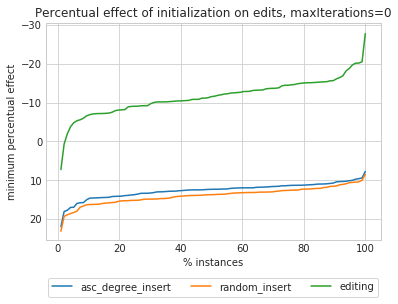

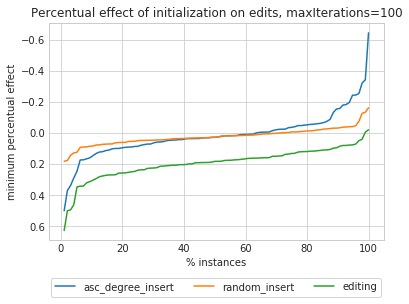

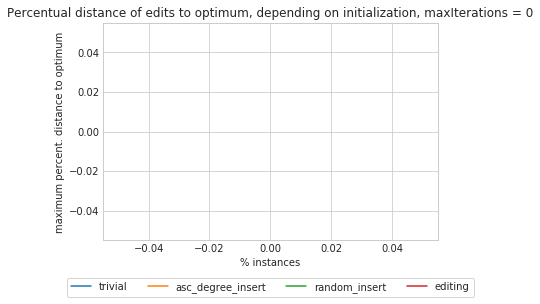

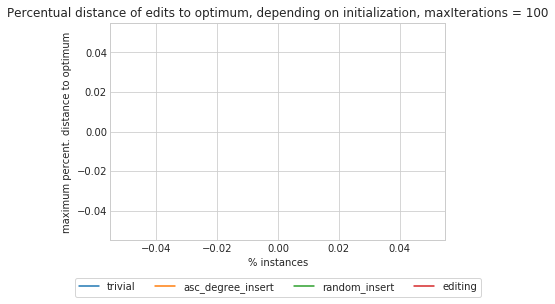

optimum\_delta\_percentual depending on initialization
            graph  maxIterations      n  trivial  asc_degree_insert  \
0       Amherst41              0   2235      NaN                NaN   
1       Amherst41            100   2235      NaN                NaN   
2      Brandeis99              0   3898      NaN                NaN   
3      Brandeis99            100   3898      NaN                NaN   
4       Bowdoin47              0   2252      NaN                NaN   
5       Bowdoin47            100   2252      NaN                NaN   
6         USFCA72              0   2682      NaN                NaN   
7         USFCA72            100   2682      NaN                NaN   
8        Lehigh96              0   5075      NaN                NaN   
9        Lehigh96            100   5075      NaN                NaN   
10          UNC28              0  18163      NaN                NaN   
11          UNC28            100  18163      NaN                NaN   
12   Georgetown15     

Average effect of initialization on usedIterations
      index  asc_degree_insert  random_insert  editing
0  facebook               0.34              1     1.48


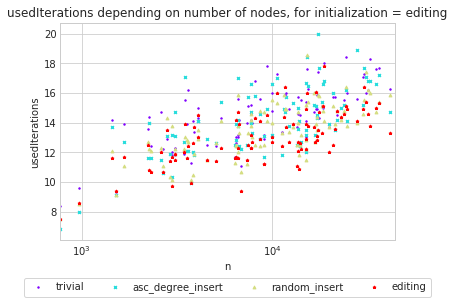

time depending on initialization
             index      n  trivial  asc_degree_insert  random_insert  editing
0        Amherst41   2235     5.27              73.49          94.51    81.84
1       Brandeis99   3898     4.23             152.12         160.04   110.67
2        Bowdoin47   2252     7.43              64.48          82.03    80.55
3          USFCA72   2682     3.61              67.30          77.32    66.41
4         Lehigh96   5075     7.98             243.53         216.81   143.95
5            UNC28  18163    32.26            1573.74        1559.57   567.95
6     Georgetown15   9414    21.80             628.21         550.55   294.85
7          Smith60   2970     5.37              96.49          88.00    83.11
8            UGA50  24389    60.93            2387.55        2593.52   857.93
9        Oberlin44   2920     4.06              85.14          92.41    78.54
10            MU78  15436    32.45            1005.55        1222.33   437.48
11      UChicago30   6591    11

Average percentual effect of sortPaths on edits
      graph maxIterations random_insert asc_degree_insert
                                   True              True
0  facebook             0          0.45              0.13
1  facebook           100         -0.01             -0.03


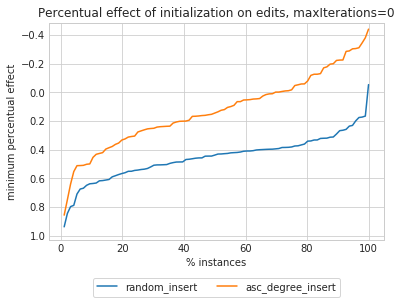

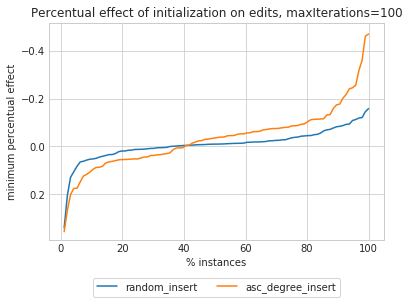

edits depending on randomness
            graph  maxIterations      n      False       True
0       Amherst41              0   2235    78784.0    78768.4
1       Amherst41            100   2235    74693.0    74018.5
2      Brandeis99              0   3898   121084.0   121336.2
3      Brandeis99            100   3898   114553.8   114060.0
4       Bowdoin47              0   2252    73985.0    73969.4
5       Bowdoin47            100   2252    69666.0    69445.2
6         USFCA72              0   2682    56403.0    56414.3
7         USFCA72            100   2682    52977.8    52688.4
8        Lehigh96              0   5075   168475.0   168026.3
9        Lehigh96            100   5075   157102.5   156347.2
10          UNC28              0  18163   688061.0   687371.5
11          UNC28            100  18163   649407.3   646773.9
12   Georgetown15              0   9414   381709.0   381382.0
13   Georgetown15            100   9414   362368.4   361283.1
14        Smith60              0   2970 

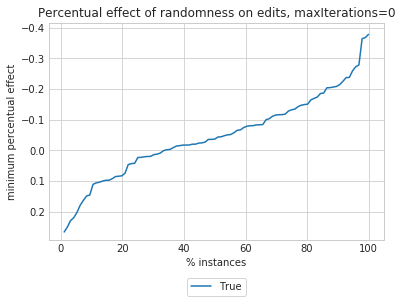

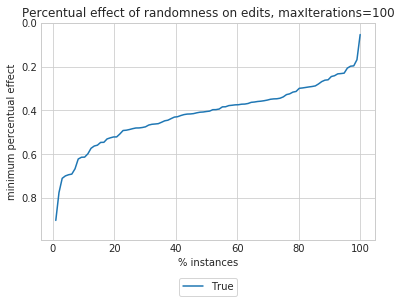

edits depending on plateauSize
            graph sortPaths asc_degree_insert                        \
                                            1        100          5   
0         USFCA72     False           52674.0    52659.1    52639.7   
1         USFCA72      True           52672.4    52651.6    52666.8   
2       Bowdoin47     False           69339.3    69333.6    69263.1   
3       Bowdoin47      True           69454.4    69412.9    69399.0   
4      Brandeis99     False          114034.2   114023.7   113970.0   
5      Brandeis99      True          114117.7   114110.8   114063.7   
6       Amherst41     False           74056.3    73911.6    73935.7   
7       Amherst41      True           74082.0    74054.9    74025.0   
8        Lehigh96     False          156285.7   156189.7   156174.7   
9        Lehigh96      True          156270.4   156295.6   156319.5   
10          UNC28     False          646817.9   646491.3   646603.8   
11          UNC28      True          646712.4 

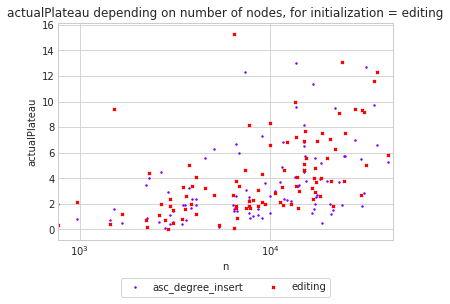

edits depending on maxIterations
            graph     initialization      n          0        100          5
0       Amherst41  asc_degree_insert   2235    78784.0    74693.0    74795.1
1       Amherst41            editing   2235    95336.0    74184.5    74313.9
2       Amherst41      random_insert   2235    78754.4    74454.0    74665.4
3       Amherst41            trivial   2235    90954.0    74438.8    74643.3
4      Brandeis99  asc_degree_insert   3898   121084.0   114553.8   114676.6
5      Brandeis99            editing   3898   162580.0   114710.8   114950.6
6      Brandeis99      random_insert   3898   120649.8   114715.1   114934.8
7      Brandeis99            trivial   3898   137567.0   114704.9   115028.6
8       Bowdoin47  asc_degree_insert   2252    73985.0    69666.0    69802.0
9       Bowdoin47            editing   2252    90428.0    69639.6    69715.5
10      Bowdoin47      random_insert   2252    73810.0    69635.4    69925.2
11      Bowdoin47            trivial   2252

In [150]:
#addInformation('facebook')
plot('facebook')